# Đây là bài làm SVM với dữ liệu FE2013. Dữ liệu đã được scale, sau đó áp dụng SVM với 2 tập dữ liệu, 1 tập đã scale, 1 tập đã scale và PCA theo optimal_components. Kết quả cho thấy SVM cho tập có PCA có accuracy tốt hơn 1 ít so với tập còn lại(48% và 49%)

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay


In [4]:
def parse_data(data: pd.DataFrame):
    """
    Đọc dữ liệu từ dataframe và trả về các mảng ảnh và nhãn
    """
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label


In [5]:
def show_img(images: np.ndarray, labels: np.ndarray):
    """
    Hiển thị ảnh và nhãn tương ứng
    """
    _, axarr = plt.subplots(nrows=2, ncols=5, figsize=(18, 9))
    axarr = axarr.flatten()
    for idx, label in enumerate(labels[:10]):
        axarr[idx].imshow(images[idx], cmap='gray')
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])
        axarr[idx].set_title("Label:{}".format(label))


In [9]:
# Tải dữ liệu từ tệp CSV
df = pd.read_csv("/kaggle/input/imcl-face/icml_face_data.csv")
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


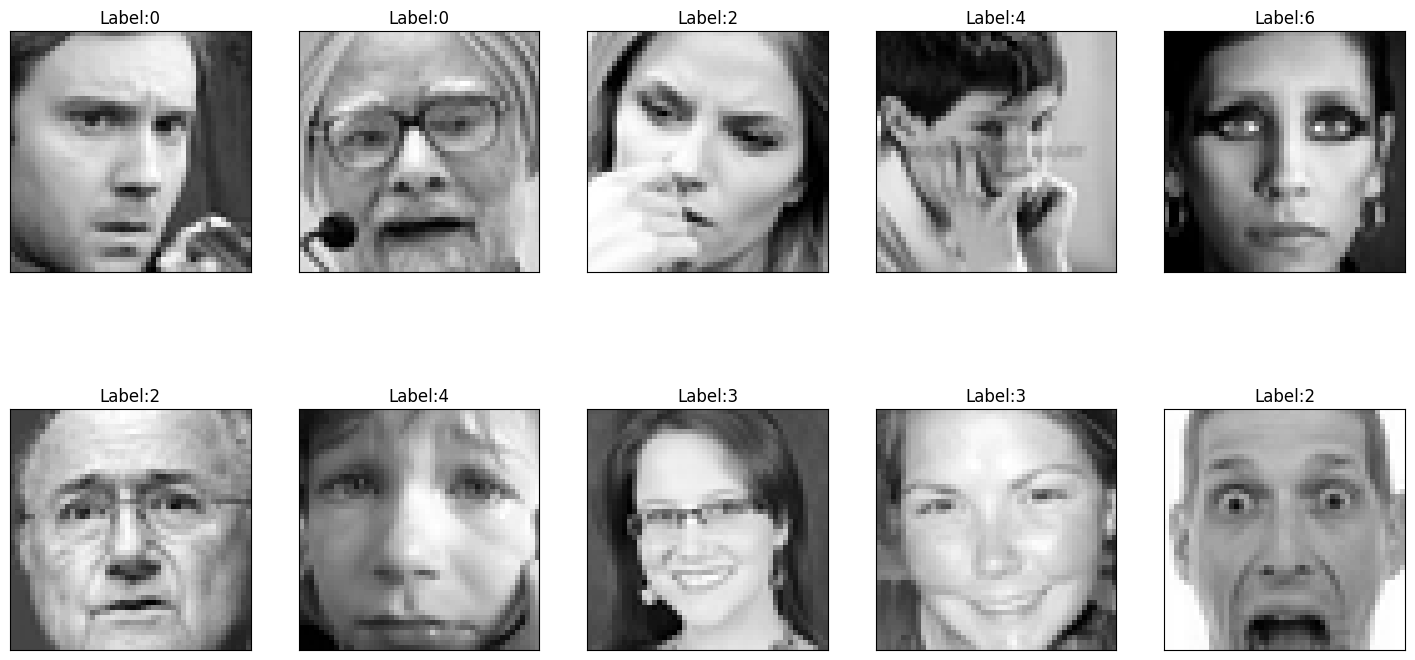

In [10]:
# Phân tích dữ liệu
images, labels = parse_data(df)

# Hiển thị hình ảnh
show_img(images, labels)

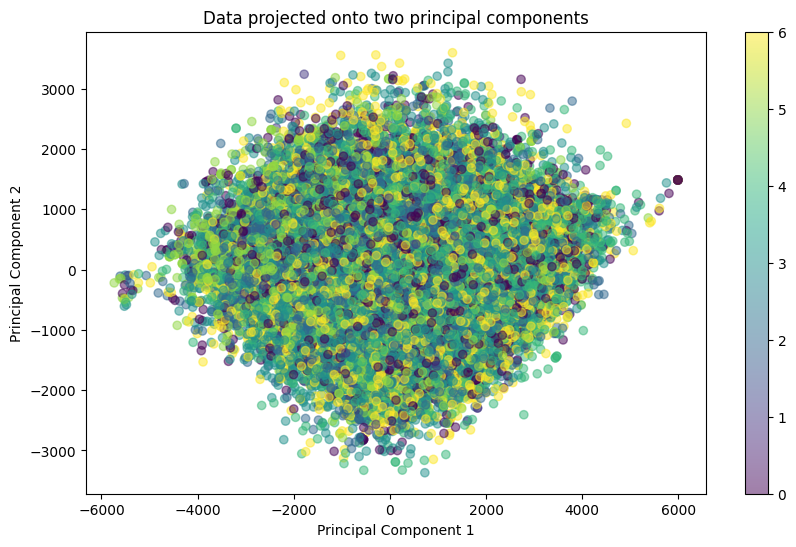

In [11]:
from sklearn.decomposition import PCA

# Biến đổi hình ảnh từ (số lượng ảnh, 48, 48) thành (số lượng ảnh, 48*48)
images_flattened = images.reshape(images.shape[0], -1)

# Áp dụng PCA
pca = PCA(n_components=2)
images_pca = pca.fit_transform(images_flattened)

# Hiển thị dữ liệu đã được chiếu
plt.figure(figsize=(10, 6))
plt.scatter(images_pca[:, 0], images_pca[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.colorbar()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Data projected onto two principal components')
plt.show()


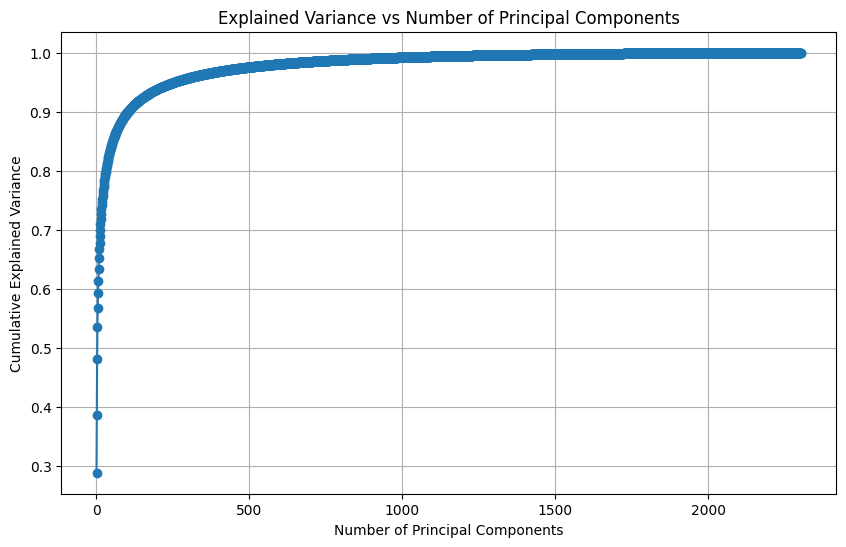

Optimal number of principal components: 255


In [12]:
# Áp dụng PCA với tất cả các thành phần chính
pca_full = PCA().fit(images_flattened)

# Kiểm tra tổng phương sai giải thích
explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Hiển thị tổng phương sai giải thích
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of Principal Components')
plt.grid(True)
plt.show()

# Chọn số lượng thành phần chính sao cho tổng phương sai giải thích đạt khoảng 95%
optimal_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f'Optimal number of principal components: {optimal_components}')


In [13]:
# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(images_flattened, labels, test_size=0.2, random_state=42)

# Chuẩn hóa dữ liệu bằng StandardScaler
scaler = StandardScaler()

# Dữ liệu trước khi giảm chiều bằng PCA
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SVM trên dữ liệu đã giảm chiều bằng PCA
pca = PCA(n_components=optimal_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [17]:
# Huấn luyện và đánh giá mô hình SVM trên dữ liệu đã giảm chiều bằng PCA
svm_pca = SVC(random_state=42)
param_grid = {'C': [0.1, 1, 10]}
grid_search_svm_pca = GridSearchCV(estimator=svm_pca, param_grid=param_grid, cv=2, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search_svm_pca.fit(X_train_pca, y_train)

svm_best_pca = grid_search_svm_pca.best_estimator_
y_pred_svm_pca = svm_best_pca.predict(X_test_pca)

accuracy_pca = accuracy_score(y_test, y_pred_svm_pca)
print("Accuracy on PCA Transformed Data:", accuracy_pca)
print(classification_report(y_test, y_pred_svm_pca))


Fitting 2 folds for each of 3 candidates, totalling 6 fits
Accuracy on PCA Transformed Data: 0.4891334633602675
              precision    recall  f1-score   support

           0       0.38      0.39      0.39       985
           1       0.82      0.52      0.63       102
           2       0.43      0.40      0.42      1043
           3       0.58      0.66      0.62      1765
           4       0.37      0.38      0.37      1210
           5       0.69      0.59      0.64       795
           6       0.46      0.44      0.45      1278

    accuracy                           0.49      7178
   macro avg       0.53      0.48      0.50      7178
weighted avg       0.49      0.49      0.49      7178



In [37]:
# Xuất ra siêu tham số đã chọn
print("Best parameters found by GridSearchCV for PCA transformed data:", grid_search_svm_pca.best_params_)

Best parameters found by GridSearchCV for PCA transformed data: {'C': 10}


In [38]:
# Huấn luyện SVM và đánh giá hiệu suất trên dữ liệu đã chuẩn hóa nhưng không giảm chiều bằng PCA
svm = SVC()
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=2, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Scaled Data:", accuracy)
print(classification_report(y_test, y_pred))

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV] END ..............................................C=0.1; total time=31.9min
[CV] END ..............................................C=0.1; total time=32.1min
[CV] END ................................................C=1; total time=29.8min
[CV] END ...............................................C=10; total time=20.2min
[CV] END ................................................C=1; total time=29.9min
[CV] END ...............................................C=10; total time=20.7min
Accuracy on Scaled Data: 0.48286430760657567
              precision    recall  f1-score   support

           0       0.37      0.37      0.37       985
           1       0.89      0.49      0.63       102
           2       0.43      0.39      0.41      1043
           3       0.57      0.67      0.62      1765
           4       0.36      0.36      0.36      1210
           5       0.70      0.59      0.64       795
           6       0.45      0.

In [40]:
# Xuất ra siêu tham số đã chọn
print("Best parameters found by GridSearchCV for PCA transformed data:", grid_search.best_params_)

Best parameters found by GridSearchCV for PCA transformed data: {'C': 10}


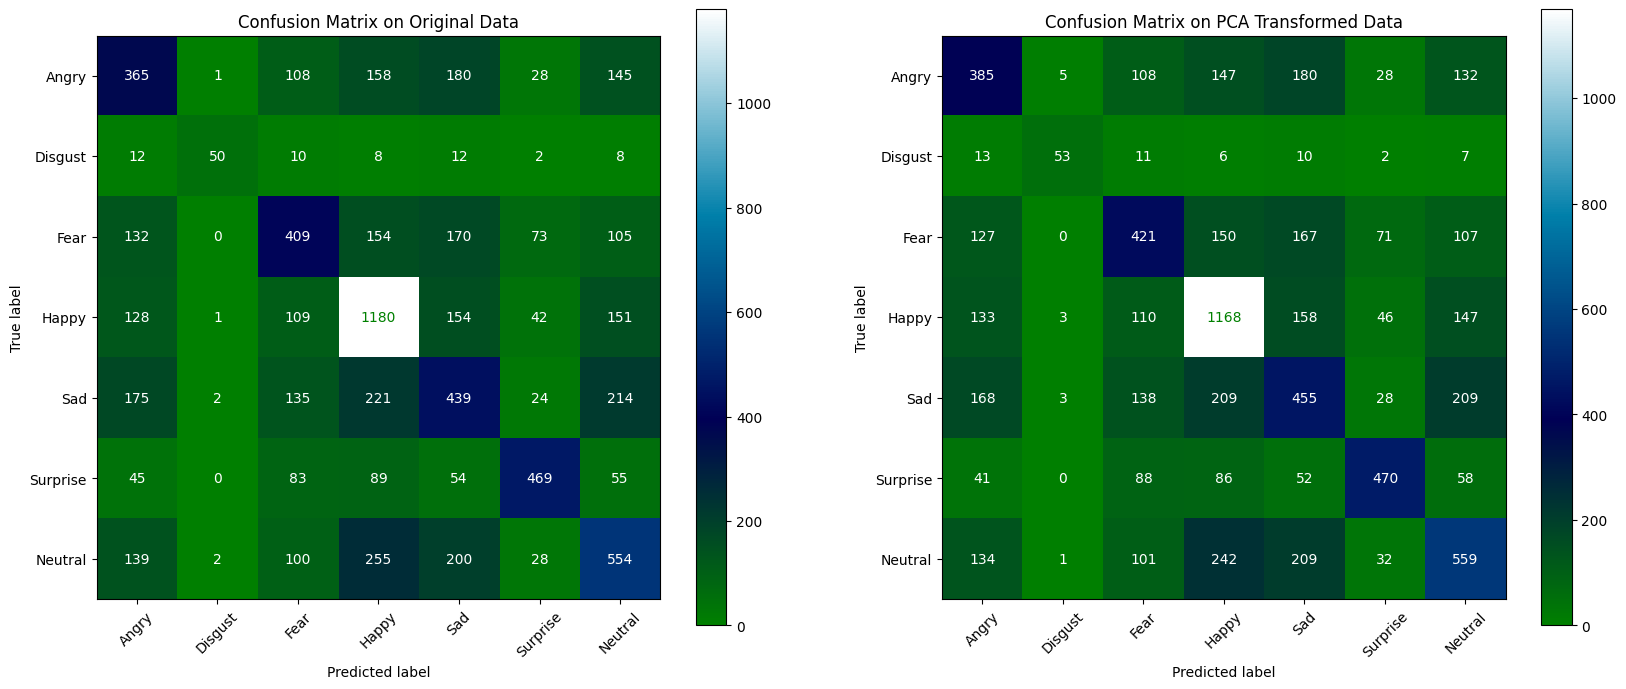

In [42]:
# Hiển thị ma trận nhầm lẫn
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_pca = confusion_matrix(y_test, y_pred_svm_pca)
disp_original = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp_pca = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_pca)

class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Ma trận nhầm lẫn cho dữ liệu gốc
disp_original.plot(ax=axes[0], xticks_rotation='vertical', cmap='ocean')
axes[0].set_title('Confusion Matrix on Original Data')
axes[0].set_xticks(np.arange(7))
axes[0].set_xticklabels(class_names, rotation=45)
axes[0].set_yticks(np.arange(7))
axes[0].set_yticklabels(class_names)

# Ma trận nhầm lẫn cho dữ liệu PCA
disp_pca.plot(ax=axes[1], xticks_rotation='vertical', cmap='ocean')
axes[1].set_title('Confusion Matrix on PCA Transformed Data')
axes[1].set_xticks(np.arange(7))
axes[1].set_xticklabels(class_names, rotation=45)
axes[1].set_yticks(np.arange(7))
axes[1].set_yticklabels(class_names)

plt.show()


# Question 2: How to determine the optimal number of principal components using pca.explained_variance_? Explain your selection process. (2 points)

pca.explained_variance_ là một mảng chứa giá trị của phương sai (variance) giải thích bởi mỗi thành phần chính trong dữ liệu. Giá trị lớn hơn biểu thị rằng thành phần chính đó giải thích được nhiều thông tin hơn từ dữ liệu gốc.

Ta cần tính tổng phương sai tích lũy để hiểu được bao nhiêu phần trăm thông tin từ dữ liệu gốc được giữ lại bởi một số lượng nhất định các thành phần chính. Để làm điều này, sử dụng pca.explained_variance_ratio_, mảng này chứa tỷ lệ phương sai được giải thích bởi mỗi thành phần chính.

Quá trình lựa chọn số lượng thành phần chính tối ưu dựa trên tổng phương sai tích lũy giúp đảm bảo rằng mô hình PCA của bạn giữ lại được một lượng lớn thông tin từ dữ liệu gốc, trong khi giảm số lượng chiều (dimensions) cần thiết để phân tích. Điều này giúp tăng hiệu suất của các mô hình học máy và giảm chi phí tính toán.

Tại đây, chọn số lượng thành phần chính mà vẫn giữ lại được 95% thông tin từ dữ liệu gốc

# Kết luận

So sánh các chỉ số
Accuracy (Độ chính xác):

+ Dữ liệu PCA: 0.4891
+ Dữ liệu chuẩn hóa: 0.4829

=> Mô hình trên dữ liệu PCA có độ chính xác cao hơn một chút so với mô hình trên dữ liệu chuẩn hóa.
Precision, Recall, F1-score:

Các chỉ số này giữa hai mô hình không chênh lệch nhiều, nhưng mô hình trên dữ liệu PCA có các chỉ số cao hơn một chút cho một số cảm xúc như 'Angry', 'Happy', 'Sad', và 'Neutral'.
Tuy nhiên, mô hình trên dữ liệu chuẩn hóa có độ chính xác cao hơn cho cảm xúc 'Disgust'.

Hiệu suất tổng thể: Mô hình trên dữ liệu đã giảm chiều bằng PCA nhỉnh hơn một chút. PCA cải thiện hiệu suất của mô hình SVM bằng cách loại bỏ nhiễu, giảm độ phức tạp, tăng tốc độ tính toán và cải thiện khả năng phân tách dữ liệu.

Loại cảm xúc dễ nhận diện nhất: 'Happy' (3)

Dữ liệu PCA:
+ Precision: 0.58
+ Recall: 0.66
+ F1-score: 0.62

Dữ liệu chuẩn hóa:
+ Precision: 0.57
+ Recall: 0.67
+ F1-score: 0.62

=> Cảm xúc 'Happy' có các chỉ số cao nhất trong cả hai mô hình, cho thấy đây là loại cảm xúc dễ nhận diện nhất.

Loại cảm xúc khó nhận diện nhất: 'Disgust' (1)

Dữ liệu PCA:
+ Precision: 0.82
+ Recall: 0.52
+ F1-score: 0.63

Dữ liệu chuẩn hóa:
+ Precision: 0.89
+ Recall: 0.49
+ F1-score: 0.63

=> Mặc dù cảm xúc 'Disgust' có độ chính xác cao (precision), nhưng độ nhạy (recall) thấp, cho thấy mô hình khó nhận diện đúng loại cảm xúc này so với các cảm xúc khác.

Do đó, mô hình PCA có hiệu suất tổng thể tốt hơn và có thể được ưu tiên sử dụng. Tuy nhiên, cần cải thiện khả năng nhận diện cảm xúc 'Disgust' vì đây là loại cảm xúc mà cả hai mô hình đều gặp khó khăn.